In [1]:
# imports required for the algorithm
import os

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
# path to load and save data
data_input_path = '../../data_in/CE_Crateus.csv'
data_output_path = '../../data_out/weather.csv'
data_output_path_npsave = '../../data_out/weather.npy'

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path, output_path):
    try:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
        
    # save file
    dataset.to_csv(output_path)

format_dataset(data_input_path, data_output_path)

            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2015-01-01           0.0        35.0        23.7        5.9              10.2   
2015-01-02           0.0        35.8        23.0       10.6              10.2   
2015-01-03          37.4        31.9        22.3        4.3               6.2   
2015-01-04          12.4        27.3        20.7        1.9               3.5   
2015-01-05          23.0        32.4        20.7        8.3               1.5   
...                  ...         ...         ...        ...               ...   
2018-04-26           0.0        31.0        20.8        8.9               0.5   
2018-04-27           0.0        31.7        22.9       10.5               0.5   
2018-04-28           0.0        31.3        21.5        9.5               0.5   
2018-04-29           3.5        28.9        22.7        2.5               0.5   
2018-04-30           0.4    

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

dataset = load_dataset(data_output_path)
values = dataset.values

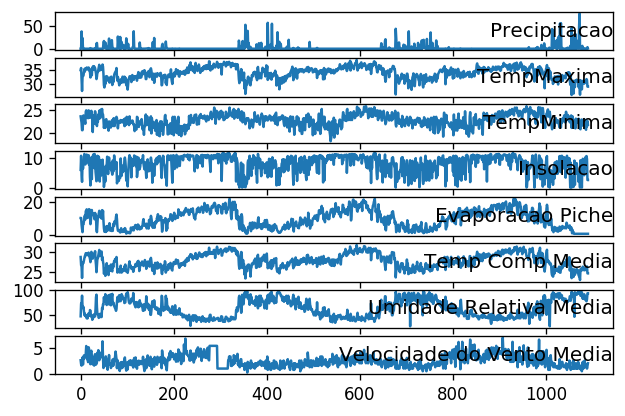

In [6]:
# plot each column in a graph
def plot_columns(values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

plot_columns(values)

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test, scaler):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test, scaler)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test, scaler):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = scaler * inv_y_hat
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = scaler * inv_y_test
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict, scaler):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test, scaler)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    rmse_max = sqrt(mean_squared_error(y_tests_max, y_hats_max))
    variance_max = explained_variance_score(y_tests_max, y_hats_max)
    maxError_max = max_error(y_tests_max, y_hats_max)
    meanAbsolutError_max = mean_absolute_error(y_tests_max, y_hats_max)
    medianAbsoluteError_max = median_absolute_error(y_tests_max, y_hats_max)
    
    rmse_min = sqrt(mean_squared_error(y_tests_min, y_hats_min))
    variance_min = explained_variance_score(y_tests_min, y_hats_min)
    maxError_min = max_error(y_tests_min, y_hats_min)
    meanAbsolutError_min = mean_absolute_error(y_tests_min, y_hats_min)
    medianAbsoluteError_min = median_absolute_error(y_tests_min, y_hats_min)
    
    print('Maximum temperature')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_max))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_max))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_max))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_max))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_max))
    
    print('\nMinimum temperature')
    print('Test RMSE -------------------------- {:.4}'.format(rmse_min))
    print('Test VARIANCE ---------------------- {:.4}'.format(variance_min))
    print('Test MAX-ERROR --------------------- {:.4}'.format(maxError_min))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError_min))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError_min))

Train on 1029 samples, validate on 1 samples
Epoch 1/1000
 - 0s - loss: 1.0302 - mean_squared_error: 1.1666 - val_loss: 0.4346 - val_mean_squared_error: 0.2758
Epoch 2/1000
 - 0s - loss: 0.3128 - mean_squared_error: 0.1982 - val_loss: 0.1962 - val_mean_squared_error: 0.0635
Epoch 3/1000
 - 0s - loss: 0.1008 - mean_squared_error: 0.0182 - val_loss: 0.0719 - val_mean_squared_error: 0.0092
Epoch 4/1000
 - 0s - loss: 0.0723 - mean_squared_error: 0.0090 - val_loss: 0.1339 - val_mean_squared_error: 0.0358
Epoch 5/1000
 - 0s - loss: 0.0644 - mean_squared_error: 0.0069 - val_loss: 0.1004 - val_mean_squared_error: 0.0197
Epoch 6/1000
 - 0s - loss: 0.0613 - mean_squared_error: 0.0063 - val_loss: 0.1009 - val_mean_squared_error: 0.0183
Epoch 7/1000
 - 0s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.1018 - val_mean_squared_error: 0.0186
Epoch 8/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0058 - val_loss: 0.0910 - val_mean_squared_error: 0.0162
Epoch 9/1000
 - 0s - loss: 0.0589 -

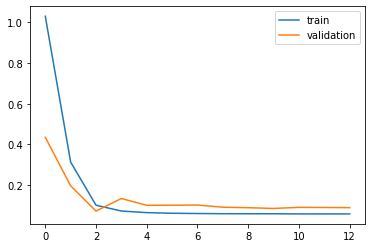


predict: [[31.70955892 22.48489384]]
real:      [[28.9 21.9]]

Train on 1028 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4728 - mean_squared_error: 0.3428 - val_loss: 0.2807 - val_mean_squared_error: 0.0877
Epoch 2/1000
 - 0s - loss: 0.1105 - mean_squared_error: 0.0193 - val_loss: 0.1460 - val_mean_squared_error: 0.0248
Epoch 3/1000
 - 0s - loss: 0.0704 - mean_squared_error: 0.0081 - val_loss: 0.0619 - val_mean_squared_error: 0.0038
Epoch 4/1000
 - 0s - loss: 0.0638 - mean_squared_error: 0.0067 - val_loss: 0.0457 - val_mean_squared_error: 0.0026
Epoch 5/1000
 - 0s - loss: 0.0620 - mean_squared_error: 0.0062 - val_loss: 0.0717 - val_mean_squared_error: 0.0052
Epoch 6/1000
 - 0s - loss: 0.0605 - mean_squared_error: 0.0060 - val_loss: 0.0672 - val_mean_squared_error: 0.0047
Epoch 7/1000
 - 0s - loss: 0.0605 - mean_squared_error: 0.0060 - val_loss: 0.0527 - val_mean_squared_error: 0.0028
Epoch 8/1000
 - 0s - loss: 0.0600 - mean_squared_error: 0.0059 - val_loss: 0.0697 - va

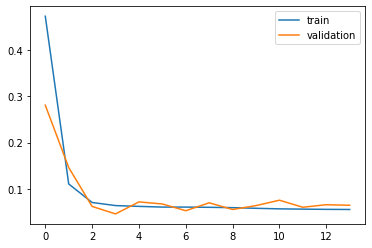


predict: [[32.10591398 21.80170668]]
real:      [[28.9 22.7]]

Train on 1027 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3652 - mean_squared_error: 0.2103 - val_loss: 0.1986 - val_mean_squared_error: 0.0399
Epoch 2/1000
 - 0s - loss: 0.0942 - mean_squared_error: 0.0137 - val_loss: 0.0703 - val_mean_squared_error: 0.0056
Epoch 3/1000
 - 0s - loss: 0.0680 - mean_squared_error: 0.0075 - val_loss: 0.0428 - val_mean_squared_error: 0.0024
Epoch 4/1000
 - 0s - loss: 0.0618 - mean_squared_error: 0.0062 - val_loss: 0.0262 - val_mean_squared_error: 8.5297e-04
Epoch 5/1000
 - 0s - loss: 0.0605 - mean_squared_error: 0.0060 - val_loss: 0.0375 - val_mean_squared_error: 0.0026
Epoch 6/1000
 - 0s - loss: 0.0607 - mean_squared_error: 0.0061 - val_loss: 0.0398 - val_mean_squared_error: 0.0031
Epoch 7/1000
 - 0s - loss: 0.0590 - mean_squared_error: 0.0057 - val_loss: 0.0354 - val_mean_squared_error: 0.0023
Epoch 8/1000
 - 0s - loss: 0.0573 - mean_squared_error: 0.0056 - val_loss: 0.0386 

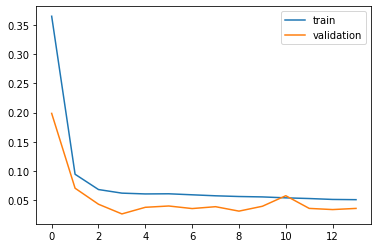


predict: [[32.55726609 22.2015462 ]]
real:      [[31.3 21.5]]

Train on 1026 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.3233 - mean_squared_error: 0.1855 - val_loss: 0.1126 - val_mean_squared_error: 0.0231
Epoch 2/1000
 - 0s - loss: 0.0961 - mean_squared_error: 0.0140 - val_loss: 0.0696 - val_mean_squared_error: 0.0052
Epoch 3/1000
 - 0s - loss: 0.0662 - mean_squared_error: 0.0070 - val_loss: 0.0532 - val_mean_squared_error: 0.0031
Epoch 4/1000
 - 0s - loss: 0.0632 - mean_squared_error: 0.0064 - val_loss: 0.0876 - val_mean_squared_error: 0.0077
Epoch 5/1000
 - 0s - loss: 0.0618 - mean_squared_error: 0.0062 - val_loss: 0.0787 - val_mean_squared_error: 0.0063
Epoch 6/1000
 - 0s - loss: 0.0612 - mean_squared_error: 0.0061 - val_loss: 0.0582 - val_mean_squared_error: 0.0035
Epoch 7/1000
 - 0s - loss: 0.0609 - mean_squared_error: 0.0061 - val_loss: 0.0565 - val_mean_squared_error: 0.0032
Epoch 8/1000
 - 0s - loss: 0.0609 - mean_squared_error: 0.0059 - val_loss: 0.1121 - va

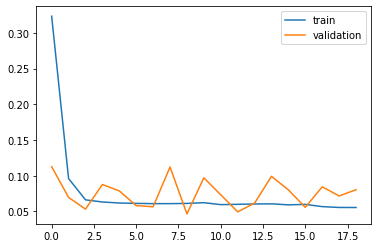


predict: [[30.93926951 21.90565423]]
real:      [[31.7 22.9]]

Train on 1025 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.1734 - mean_squared_error: 1.6638 - val_loss: 0.5946 - val_mean_squared_error: 0.6019
Epoch 2/1000
 - 0s - loss: 0.4461 - mean_squared_error: 0.3731 - val_loss: 0.0461 - val_mean_squared_error: 0.0036
Epoch 3/1000
 - 0s - loss: 0.1063 - mean_squared_error: 0.0198 - val_loss: 0.1239 - val_mean_squared_error: 0.0173
Epoch 4/1000
 - 0s - loss: 0.0729 - mean_squared_error: 0.0087 - val_loss: 0.1327 - val_mean_squared_error: 0.0181
Epoch 5/1000
 - 0s - loss: 0.0656 - mean_squared_error: 0.0074 - val_loss: 0.0846 - val_mean_squared_error: 0.0075
Epoch 6/1000
 - 0s - loss: 0.0630 - mean_squared_error: 0.0065 - val_loss: 0.1145 - val_mean_squared_error: 0.0142
Epoch 7/1000
 - 0s - loss: 0.0609 - mean_squared_error: 0.0060 - val_loss: 0.0939 - val_mean_squared_error: 0.0096
Epoch 8/1000
 - 0s - loss: 0.0597 - mean_squared_error: 0.0059 - val_loss: 0.0918 - va

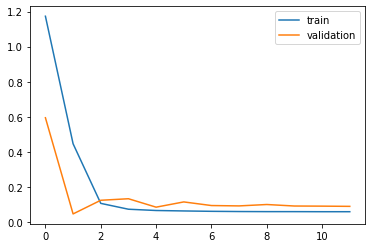


predict: [[28.67916878 20.7710885 ]]
real:      [[31.  20.8]]

Train on 1024 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6811 - mean_squared_error: 0.5754 - val_loss: 0.0979 - val_mean_squared_error: 0.0103
Epoch 2/1000
 - 0s - loss: 0.1262 - mean_squared_error: 0.0245 - val_loss: 0.0060 - val_mean_squared_error: 5.8608e-05
Epoch 3/1000
 - 0s - loss: 0.0795 - mean_squared_error: 0.0107 - val_loss: 0.1158 - val_mean_squared_error: 0.0185
Epoch 4/1000
 - 0s - loss: 0.0645 - mean_squared_error: 0.0069 - val_loss: 0.0819 - val_mean_squared_error: 0.0085
Epoch 5/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0060 - val_loss: 0.0639 - val_mean_squared_error: 0.0049
Epoch 6/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0058 - val_loss: 0.0672 - val_mean_squared_error: 0.0050
Epoch 7/1000
 - 0s - loss: 0.0593 - mean_squared_error: 0.0058 - val_loss: 0.0576 - val_mean_squared_error: 0.0036
Epoch 8/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0059 - val_loss: 0.0547 

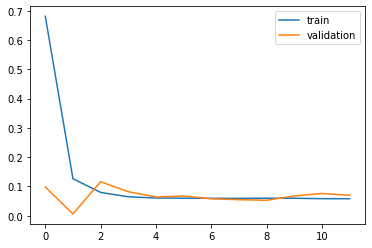


predict: [[30.3540813  21.43797956]]
real:      [[30.7 21. ]]

Train on 1023 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6551 - mean_squared_error: 0.6274 - val_loss: 0.1071 - val_mean_squared_error: 0.0126
Epoch 2/1000
 - 0s - loss: 0.1228 - mean_squared_error: 0.0276 - val_loss: 0.0795 - val_mean_squared_error: 0.0123
Epoch 3/1000
 - 0s - loss: 0.0770 - mean_squared_error: 0.0099 - val_loss: 0.1105 - val_mean_squared_error: 0.0209
Epoch 4/1000
 - 0s - loss: 0.0632 - mean_squared_error: 0.0066 - val_loss: 0.0721 - val_mean_squared_error: 0.0104
Epoch 5/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0059 - val_loss: 0.0642 - val_mean_squared_error: 0.0063
Epoch 6/1000
 - 0s - loss: 0.0594 - mean_squared_error: 0.0058 - val_loss: 0.0688 - val_mean_squared_error: 0.0071
Epoch 7/1000
 - 0s - loss: 0.0593 - mean_squared_error: 0.0057 - val_loss: 0.0797 - val_mean_squared_error: 0.0081
Epoch 8/1000
 - 0s - loss: 0.0601 - mean_squared_error: 0.0058 - val_loss: 0.0712 - va

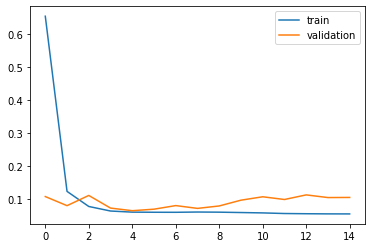


predict: [[31.9671602  22.89174596]]
real:      [[30.6 21.7]]

Train on 1022 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8455 - mean_squared_error: 0.8712 - val_loss: 0.1086 - val_mean_squared_error: 0.0167
Epoch 2/1000
 - 0s - loss: 0.1223 - mean_squared_error: 0.0244 - val_loss: 0.0504 - val_mean_squared_error: 0.0043
Epoch 3/1000
 - 0s - loss: 0.0765 - mean_squared_error: 0.0093 - val_loss: 0.0772 - val_mean_squared_error: 0.0116
Epoch 4/1000
 - 0s - loss: 0.0634 - mean_squared_error: 0.0064 - val_loss: 0.0726 - val_mean_squared_error: 0.0103
Epoch 5/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0058 - val_loss: 0.0726 - val_mean_squared_error: 0.0093
Epoch 6/1000
 - 0s - loss: 0.0590 - mean_squared_error: 0.0057 - val_loss: 0.0615 - val_mean_squared_error: 0.0074
Epoch 7/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0058 - val_loss: 0.0582 - val_mean_squared_error: 0.0050
Epoch 8/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0058 - val_loss: 0.0509 - va

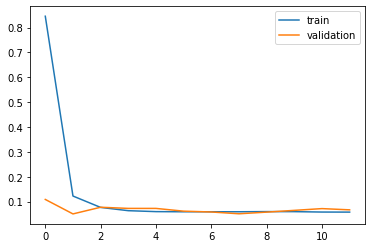


predict: [[31.85634298 23.59600398]]
real:      [[30.3 22.3]]

Train on 1021 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8843 - mean_squared_error: 1.1346 - val_loss: 0.2563 - val_mean_squared_error: 0.0667
Epoch 2/1000
 - 0s - loss: 0.1620 - mean_squared_error: 0.0435 - val_loss: 0.1032 - val_mean_squared_error: 0.0149
Epoch 3/1000
 - 0s - loss: 0.0799 - mean_squared_error: 0.0101 - val_loss: 0.0695 - val_mean_squared_error: 0.0083
Epoch 4/1000
 - 0s - loss: 0.0605 - mean_squared_error: 0.0061 - val_loss: 0.0431 - val_mean_squared_error: 0.0035
Epoch 5/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0059 - val_loss: 0.0301 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 0s - loss: 0.0600 - mean_squared_error: 0.0059 - val_loss: 0.0411 - val_mean_squared_error: 0.0028
Epoch 7/1000
 - 0s - loss: 0.0589 - mean_squared_error: 0.0056 - val_loss: 0.0696 - val_mean_squared_error: 0.0061
Epoch 8/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0059 - val_loss: 0.0254 - va

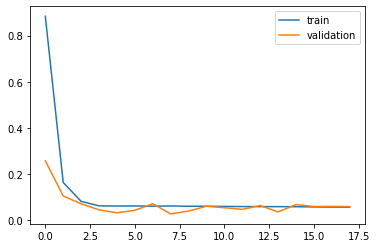


predict: [[31.42701192 22.69001515]]
real:      [[30.  23.1]]

Train on 1020 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.8775 - mean_squared_error: 0.8377 - val_loss: 0.2979 - val_mean_squared_error: 0.0990
Epoch 2/1000
 - 0s - loss: 0.1742 - mean_squared_error: 0.0477 - val_loss: 0.1694 - val_mean_squared_error: 0.0288
Epoch 3/1000
 - 0s - loss: 0.0818 - mean_squared_error: 0.0105 - val_loss: 0.0506 - val_mean_squared_error: 0.0034
Epoch 4/1000
 - 0s - loss: 0.0642 - mean_squared_error: 0.0066 - val_loss: 0.0525 - val_mean_squared_error: 0.0044
Epoch 5/1000
 - 0s - loss: 0.0621 - mean_squared_error: 0.0061 - val_loss: 0.0625 - val_mean_squared_error: 0.0043
Epoch 6/1000
 - 0s - loss: 0.0602 - mean_squared_error: 0.0059 - val_loss: 0.0639 - val_mean_squared_error: 0.0060
Epoch 7/1000
 - 0s - loss: 0.0597 - mean_squared_error: 0.0058 - val_loss: 0.0488 - val_mean_squared_error: 0.0026
Epoch 8/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0059 - val_loss: 0.0479 - va

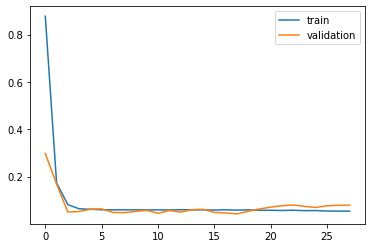


predict: [[31.3981887  23.03242923]]
real:      [[31.1 22.8]]

Train on 1019 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.2817 - mean_squared_error: 0.1477 - val_loss: 0.1064 - val_mean_squared_error: 0.0131
Epoch 2/1000
 - 0s - loss: 0.0928 - mean_squared_error: 0.0128 - val_loss: 0.0516 - val_mean_squared_error: 0.0046
Epoch 3/1000
 - 0s - loss: 0.0707 - mean_squared_error: 0.0078 - val_loss: 0.0432 - val_mean_squared_error: 0.0025
Epoch 4/1000
 - 0s - loss: 0.0642 - mean_squared_error: 0.0065 - val_loss: 0.0358 - val_mean_squared_error: 0.0022
Epoch 5/1000
 - 0s - loss: 0.0634 - mean_squared_error: 0.0064 - val_loss: 0.0377 - val_mean_squared_error: 0.0027
Epoch 6/1000
 - 0s - loss: 0.0627 - mean_squared_error: 0.0063 - val_loss: 0.0473 - val_mean_squared_error: 0.0033
Epoch 7/1000
 - 0s - loss: 0.0619 - mean_squared_error: 0.0061 - val_loss: 0.0435 - val_mean_squared_error: 0.0027
Epoch 8/1000
 - 0s - loss: 0.0638 - mean_squared_error: 0.0066 - val_loss: 0.0304 - va

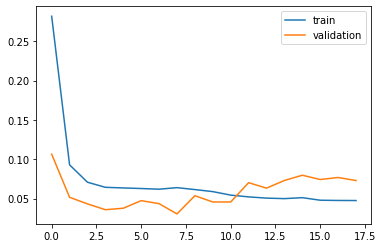


predict: [[31.49547568 22.57309185]]
real:      [[31.1 22.3]]

Train on 1018 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.9599 - mean_squared_error: 1.0149 - val_loss: 0.2465 - val_mean_squared_error: 0.0802
Epoch 2/1000
 - 0s - loss: 0.1752 - mean_squared_error: 0.0524 - val_loss: 0.1223 - val_mean_squared_error: 0.0255
Epoch 3/1000
 - 0s - loss: 0.0775 - mean_squared_error: 0.0097 - val_loss: 0.0978 - val_mean_squared_error: 0.0137
Epoch 4/1000
 - 0s - loss: 0.0675 - mean_squared_error: 0.0074 - val_loss: 0.0815 - val_mean_squared_error: 0.0078
Epoch 5/1000
 - 0s - loss: 0.0631 - mean_squared_error: 0.0065 - val_loss: 0.0951 - val_mean_squared_error: 0.0108
Epoch 6/1000
 - 0s - loss: 0.0621 - mean_squared_error: 0.0063 - val_loss: 0.0915 - val_mean_squared_error: 0.0093
Epoch 7/1000
 - 0s - loss: 0.0618 - mean_squared_error: 0.0062 - val_loss: 0.0809 - val_mean_squared_error: 0.0069
Epoch 8/1000
 - 0s - loss: 0.0608 - mean_squared_error: 0.0061 - val_loss: 0.0676 - va

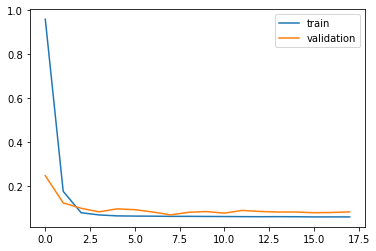


predict: [[31.88256443 22.12303931]]
real:      [[31.  22.8]]

Train on 1017 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.7342 - mean_squared_error: 0.8450 - val_loss: 0.3813 - val_mean_squared_error: 0.2031
Epoch 2/1000
 - 0s - loss: 0.2930 - mean_squared_error: 0.1719 - val_loss: 0.2162 - val_mean_squared_error: 0.0719
Epoch 3/1000
 - 0s - loss: 0.0867 - mean_squared_error: 0.0129 - val_loss: 0.1173 - val_mean_squared_error: 0.0216
Epoch 4/1000
 - 0s - loss: 0.0672 - mean_squared_error: 0.0073 - val_loss: 0.1630 - val_mean_squared_error: 0.0356
Epoch 5/1000
 - 0s - loss: 0.0636 - mean_squared_error: 0.0065 - val_loss: 0.1350 - val_mean_squared_error: 0.0329
Epoch 6/1000
 - 0s - loss: 0.0620 - mean_squared_error: 0.0061 - val_loss: 0.1430 - val_mean_squared_error: 0.0309
Epoch 7/1000
 - 0s - loss: 0.0625 - mean_squared_error: 0.0062 - val_loss: 0.1272 - val_mean_squared_error: 0.0273
Epoch 8/1000
 - 0s - loss: 0.0618 - mean_squared_error: 0.0061 - val_loss: 0.1353 - va

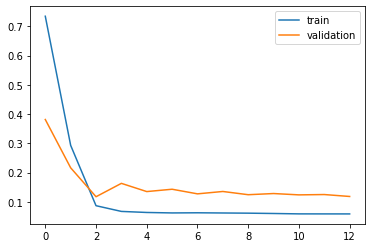


predict: [[32.14248957 22.03376539]]
real:      [[30.7 21.7]]

Train on 1016 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6733 - mean_squared_error: 0.6342 - val_loss: 0.4102 - val_mean_squared_error: 0.1683
Epoch 2/1000
 - 0s - loss: 0.1750 - mean_squared_error: 0.0466 - val_loss: 0.1098 - val_mean_squared_error: 0.0136
Epoch 3/1000
 - 0s - loss: 0.0803 - mean_squared_error: 0.0108 - val_loss: 0.1113 - val_mean_squared_error: 0.0178
Epoch 4/1000
 - 0s - loss: 0.0640 - mean_squared_error: 0.0067 - val_loss: 0.0927 - val_mean_squared_error: 0.0129
Epoch 5/1000
 - 0s - loss: 0.0611 - mean_squared_error: 0.0061 - val_loss: 0.0896 - val_mean_squared_error: 0.0155
Epoch 6/1000
 - 0s - loss: 0.0601 - mean_squared_error: 0.0060 - val_loss: 0.0832 - val_mean_squared_error: 0.0133
Epoch 7/1000
 - 0s - loss: 0.0600 - mean_squared_error: 0.0059 - val_loss: 0.0968 - val_mean_squared_error: 0.0173
Epoch 8/1000
 - 0s - loss: 0.0607 - mean_squared_error: 0.0060 - val_loss: 0.0863 - va

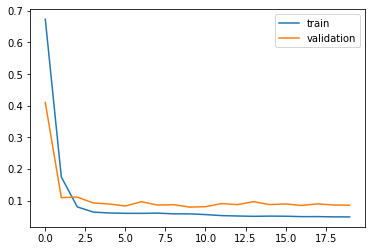


predict: [[31.40975504 22.34652913]]
real:      [[27.9 23. ]]

Train on 1015 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.9493 - mean_squared_error: 0.9820 - val_loss: 0.2486 - val_mean_squared_error: 0.0857
Epoch 2/1000
 - 0s - loss: 0.1941 - mean_squared_error: 0.0569 - val_loss: 0.1010 - val_mean_squared_error: 0.0116
Epoch 3/1000
 - 0s - loss: 0.0849 - mean_squared_error: 0.0123 - val_loss: 0.0858 - val_mean_squared_error: 0.0080
Epoch 4/1000
 - 0s - loss: 0.0747 - mean_squared_error: 0.0091 - val_loss: 0.0942 - val_mean_squared_error: 0.0126
Epoch 5/1000
 - 0s - loss: 0.0657 - mean_squared_error: 0.0069 - val_loss: 0.0990 - val_mean_squared_error: 0.0118
Epoch 6/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0061 - val_loss: 0.0814 - val_mean_squared_error: 0.0070
Epoch 7/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0060 - val_loss: 0.0878 - val_mean_squared_error: 0.0082
Epoch 8/1000
 - 0s - loss: 0.0602 - mean_squared_error: 0.0060 - val_loss: 0.0759 - va

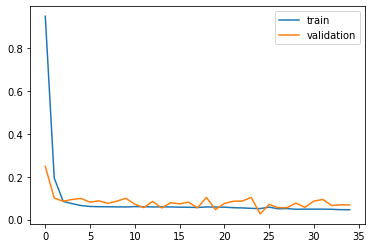


predict: [[30.33608068 20.22478121]]
real:      [[29.5 23. ]]

Train on 1014 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.9426 - mean_squared_error: 1.0008 - val_loss: 0.3577 - val_mean_squared_error: 0.2551
Epoch 2/1000
 - 0s - loss: 0.2822 - mean_squared_error: 0.1618 - val_loss: 0.1803 - val_mean_squared_error: 0.0455
Epoch 3/1000
 - 0s - loss: 0.0928 - mean_squared_error: 0.0137 - val_loss: 0.0649 - val_mean_squared_error: 0.0044
Epoch 4/1000
 - 0s - loss: 0.0713 - mean_squared_error: 0.0079 - val_loss: 0.0777 - val_mean_squared_error: 0.0067
Epoch 5/1000
 - 0s - loss: 0.0681 - mean_squared_error: 0.0073 - val_loss: 0.1016 - val_mean_squared_error: 0.0116
Epoch 6/1000
 - 0s - loss: 0.0635 - mean_squared_error: 0.0064 - val_loss: 0.1165 - val_mean_squared_error: 0.0136
Epoch 7/1000
 - 0s - loss: 0.0639 - mean_squared_error: 0.0068 - val_loss: 0.0985 - val_mean_squared_error: 0.0097
Epoch 8/1000
 - 0s - loss: 0.0634 - mean_squared_error: 0.0064 - val_loss: 0.0857 - va

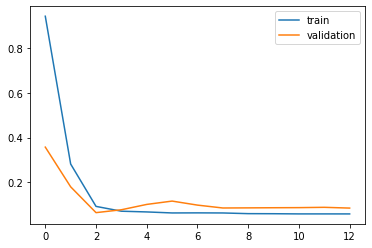


predict: [[32.11492885 22.55028206]]
real:      [[30.7 21.8]]

Train on 1013 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.4517 - mean_squared_error: 0.3182 - val_loss: 0.4078 - val_mean_squared_error: 0.1794
Epoch 2/1000
 - 0s - loss: 0.1130 - mean_squared_error: 0.0191 - val_loss: 0.1760 - val_mean_squared_error: 0.0616
Epoch 3/1000
 - 0s - loss: 0.0727 - mean_squared_error: 0.0083 - val_loss: 0.2055 - val_mean_squared_error: 0.0567
Epoch 4/1000
 - 0s - loss: 0.0626 - mean_squared_error: 0.0062 - val_loss: 0.2029 - val_mean_squared_error: 0.0514
Epoch 5/1000
 - 0s - loss: 0.0611 - mean_squared_error: 0.0060 - val_loss: 0.1887 - val_mean_squared_error: 0.0463
Epoch 6/1000
 - 0s - loss: 0.0611 - mean_squared_error: 0.0061 - val_loss: 0.1877 - val_mean_squared_error: 0.0479
Epoch 7/1000
 - 0s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.1895 - val_mean_squared_error: 0.0501
Epoch 8/1000
 - 0s - loss: 0.0595 - mean_squared_error: 0.0058 - val_loss: 0.2160 - va

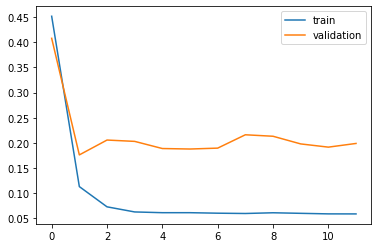


predict: [[33.23952424 21.62011507]]
real:      [[31.3 20.9]]

Train on 1012 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.9222 - mean_squared_error: 1.0159 - val_loss: 0.1531 - val_mean_squared_error: 0.0374
Epoch 2/1000
 - 0s - loss: 0.1648 - mean_squared_error: 0.0466 - val_loss: 0.1873 - val_mean_squared_error: 0.0619
Epoch 3/1000
 - 0s - loss: 0.0816 - mean_squared_error: 0.0109 - val_loss: 0.1310 - val_mean_squared_error: 0.0226
Epoch 4/1000
 - 0s - loss: 0.0664 - mean_squared_error: 0.0076 - val_loss: 0.1257 - val_mean_squared_error: 0.0178
Epoch 5/1000
 - 0s - loss: 0.0630 - mean_squared_error: 0.0065 - val_loss: 0.1442 - val_mean_squared_error: 0.0238
Epoch 6/1000
 - 0s - loss: 0.0609 - mean_squared_error: 0.0061 - val_loss: 0.1431 - val_mean_squared_error: 0.0225
Epoch 7/1000
 - 0s - loss: 0.0605 - mean_squared_error: 0.0060 - val_loss: 0.1346 - val_mean_squared_error: 0.0199
Epoch 8/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0059 - val_loss: 0.1210 - va

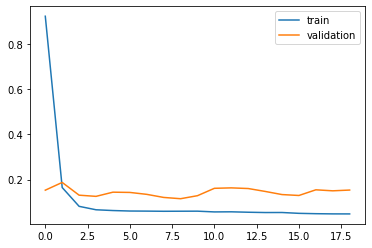


predict: [[30.07947723 22.34518722]]
real:      [[25.9 21.2]]

Train on 1011 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.5249 - mean_squared_error: 0.4038 - val_loss: 0.2501 - val_mean_squared_error: 0.0638
Epoch 2/1000
 - 0s - loss: 0.1098 - mean_squared_error: 0.0181 - val_loss: 0.0963 - val_mean_squared_error: 0.0169
Epoch 3/1000
 - 0s - loss: 0.0734 - mean_squared_error: 0.0090 - val_loss: 0.0548 - val_mean_squared_error: 0.0054
Epoch 4/1000
 - 0s - loss: 0.0642 - mean_squared_error: 0.0067 - val_loss: 0.0665 - val_mean_squared_error: 0.0044
Epoch 5/1000
 - 0s - loss: 0.0608 - mean_squared_error: 0.0060 - val_loss: 0.0641 - val_mean_squared_error: 0.0043
Epoch 6/1000
 - 0s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.0815 - val_mean_squared_error: 0.0069
Epoch 7/1000
 - 0s - loss: 0.0609 - mean_squared_error: 0.0061 - val_loss: 0.0485 - val_mean_squared_error: 0.0024
Epoch 8/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0059 - val_loss: 0.0616 - va

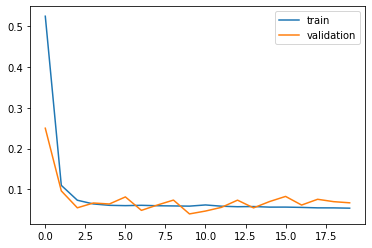


predict: [[31.4074656  21.79800915]]
real:      [[29.2 21.1]]

Train on 1010 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 0.6849 - mean_squared_error: 0.5590 - val_loss: 0.4786 - val_mean_squared_error: 0.2322
Epoch 2/1000
 - 0s - loss: 0.1903 - mean_squared_error: 0.0577 - val_loss: 0.0998 - val_mean_squared_error: 0.0158
Epoch 3/1000
 - 0s - loss: 0.0766 - mean_squared_error: 0.0091 - val_loss: 0.1401 - val_mean_squared_error: 0.0238
Epoch 4/1000
 - 0s - loss: 0.0660 - mean_squared_error: 0.0068 - val_loss: 0.0888 - val_mean_squared_error: 0.0140
Epoch 5/1000
 - 0s - loss: 0.0632 - mean_squared_error: 0.0066 - val_loss: 0.1099 - val_mean_squared_error: 0.0188
Epoch 6/1000
 - 0s - loss: 0.0606 - mean_squared_error: 0.0061 - val_loss: 0.1039 - val_mean_squared_error: 0.0196
Epoch 7/1000
 - 0s - loss: 0.0603 - mean_squared_error: 0.0060 - val_loss: 0.1258 - val_mean_squared_error: 0.0310
Epoch 8/1000
 - 0s - loss: 0.0647 - mean_squared_error: 0.0070 - val_loss: 0.1430 - va

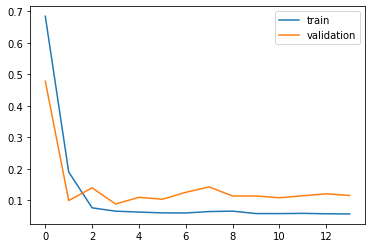


predict: [[31.14162495 22.36051197]]
real:      [[31.1 21.7]]

Train on 1009 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.3135 - mean_squared_error: 1.7622 - val_loss: 1.1739 - val_mean_squared_error: 1.3781
Epoch 2/1000
 - 0s - loss: 1.1086 - mean_squared_error: 1.2665 - val_loss: 0.6312 - val_mean_squared_error: 0.5037
Epoch 3/1000
 - 0s - loss: 0.4057 - mean_squared_error: 0.2502 - val_loss: 0.0405 - val_mean_squared_error: 0.0027
Epoch 4/1000
 - 0s - loss: 0.0974 - mean_squared_error: 0.0147 - val_loss: 0.0631 - val_mean_squared_error: 0.0050
Epoch 5/1000
 - 0s - loss: 0.0684 - mean_squared_error: 0.0074 - val_loss: 0.0556 - val_mean_squared_error: 0.0033
Epoch 6/1000
 - 0s - loss: 0.0605 - mean_squared_error: 0.0060 - val_loss: 0.0428 - val_mean_squared_error: 0.0018
Epoch 7/1000
 - 0s - loss: 0.0617 - mean_squared_error: 0.0063 - val_loss: 0.0380 - val_mean_squared_error: 0.0016
Epoch 8/1000
 - 0s - loss: 0.0597 - mean_squared_error: 0.0059 - val_loss: 0.0496 - va

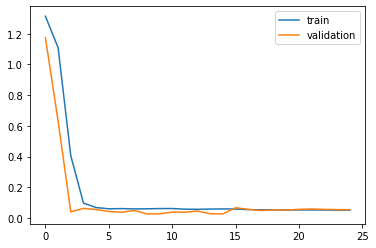


predict: [[30.61449609 22.45664761]]
real:      [[28.7 23.2]]

Train on 1008 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.1117 - mean_squared_error: 1.7201 - val_loss: 0.9474 - val_mean_squared_error: 1.5794
Epoch 2/1000
 - 0s - loss: 0.8922 - mean_squared_error: 1.4514 - val_loss: 0.6640 - val_mean_squared_error: 0.8167
Epoch 3/1000
 - 0s - loss: 0.5867 - mean_squared_error: 0.6506 - val_loss: 0.2582 - val_mean_squared_error: 0.1128
Epoch 4/1000
 - 0s - loss: 0.1673 - mean_squared_error: 0.0568 - val_loss: 0.2052 - val_mean_squared_error: 0.0651
Epoch 5/1000
 - 0s - loss: 0.0839 - mean_squared_error: 0.0121 - val_loss: 0.0501 - val_mean_squared_error: 0.0049
Epoch 6/1000
 - 0s - loss: 0.0690 - mean_squared_error: 0.0076 - val_loss: 0.0899 - val_mean_squared_error: 0.0107
Epoch 7/1000
 - 0s - loss: 0.0656 - mean_squared_error: 0.0068 - val_loss: 0.0901 - val_mean_squared_error: 0.0106
Epoch 8/1000
 - 0s - loss: 0.0659 - mean_squared_error: 0.0068 - val_loss: 0.0808 - va

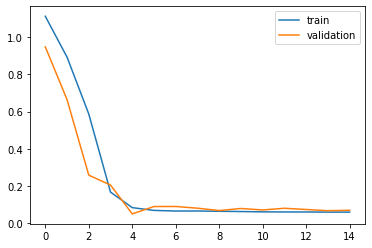


predict: [[33.27597278 22.37369019]]
real:      [[31.2 22.3]]

Train on 1007 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.9124 - mean_squared_error: 0.9916 - val_loss: 0.4294 - val_mean_squared_error: 0.3137
Epoch 2/1000
 - 0s - loss: 0.3895 - mean_squared_error: 0.2375 - val_loss: 0.0971 - val_mean_squared_error: 0.0164
Epoch 3/1000
 - 0s - loss: 0.1116 - mean_squared_error: 0.0224 - val_loss: 0.1261 - val_mean_squared_error: 0.0286
Epoch 4/1000
 - 0s - loss: 0.0741 - mean_squared_error: 0.0089 - val_loss: 0.0663 - val_mean_squared_error: 0.0067
Epoch 5/1000
 - 0s - loss: 0.0648 - mean_squared_error: 0.0069 - val_loss: 0.0607 - val_mean_squared_error: 0.0057
Epoch 6/1000
 - 0s - loss: 0.0620 - mean_squared_error: 0.0063 - val_loss: 0.0645 - val_mean_squared_error: 0.0078
Epoch 7/1000
 - 0s - loss: 0.0606 - mean_squared_error: 0.0059 - val_loss: 0.0507 - val_mean_squared_error: 0.0043
Epoch 8/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0058 - val_loss: 0.0575 - va

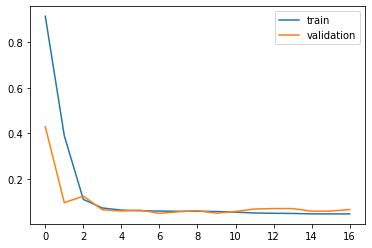


predict: [[32.25365617 22.81060951]]
real:      [[31.1 22.3]]

Train on 1006 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.9408 - mean_squared_error: 0.9498 - val_loss: 0.4569 - val_mean_squared_error: 0.2130
Epoch 2/1000
 - 0s - loss: 0.2109 - mean_squared_error: 0.0695 - val_loss: 0.1446 - val_mean_squared_error: 0.0223
Epoch 3/1000
 - 0s - loss: 0.0860 - mean_squared_error: 0.0114 - val_loss: 0.0418 - val_mean_squared_error: 0.0034
Epoch 4/1000
 - 0s - loss: 0.0680 - mean_squared_error: 0.0072 - val_loss: 0.0396 - val_mean_squared_error: 0.0031
Epoch 5/1000
 - 0s - loss: 0.0608 - mean_squared_error: 0.0059 - val_loss: 0.0320 - val_mean_squared_error: 0.0015
Epoch 6/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0058 - val_loss: 0.0409 - val_mean_squared_error: 0.0024
Epoch 7/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0058 - val_loss: 0.0219 - val_mean_squared_error: 7.7553e-04
Epoch 8/1000
 - 0s - loss: 0.0600 - mean_squared_error: 0.0058 - val_loss: 0.0431 

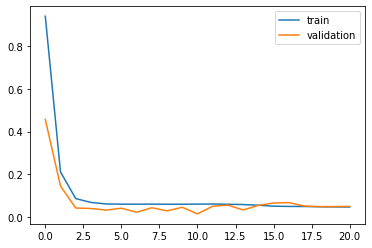


predict: [[31.2502533  23.38075882]]
real:      [[31.  22.8]]

Train on 1005 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.3077 - mean_squared_error: 0.1649 - val_loss: 0.0544 - val_mean_squared_error: 0.0031
Epoch 2/1000
 - 0s - loss: 0.0879 - mean_squared_error: 0.0125 - val_loss: 0.0698 - val_mean_squared_error: 0.0051
Epoch 3/1000
 - 0s - loss: 0.0659 - mean_squared_error: 0.0068 - val_loss: 0.0400 - val_mean_squared_error: 0.0023
Epoch 4/1000
 - 0s - loss: 0.0575 - mean_squared_error: 0.0055 - val_loss: 0.0315 - val_mean_squared_error: 0.0018
Epoch 5/1000
 - 0s - loss: 0.0553 - mean_squared_error: 0.0052 - val_loss: 0.0443 - val_mean_squared_error: 0.0036
Epoch 6/1000
 - 0s - loss: 0.0542 - mean_squared_error: 0.0050 - val_loss: 0.0411 - val_mean_squared_error: 0.0033
Epoch 7/1000
 - 0s - loss: 0.0532 - mean_squared_error: 0.0048 - val_loss: 0.0504 - val_mean_squared_error: 0.0045
Epoch 8/1000
 - 0s - loss: 0.0528 - mean_squared_error: 0.0048 - val_loss: 0.0485 - va

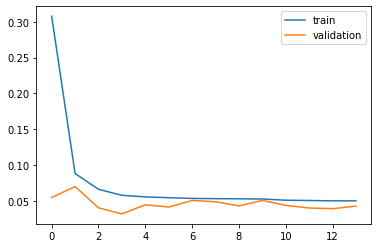


predict: [[30.91820923 22.37290146]]
real:      [[31.5 23. ]]

Train on 1004 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6604 - mean_squared_error: 0.6866 - val_loss: 0.2105 - val_mean_squared_error: 0.0627
Epoch 2/1000
 - 0s - loss: 0.1405 - mean_squared_error: 0.0302 - val_loss: 0.1839 - val_mean_squared_error: 0.0420
Epoch 3/1000
 - 0s - loss: 0.0868 - mean_squared_error: 0.0129 - val_loss: 0.0617 - val_mean_squared_error: 0.0042
Epoch 4/1000
 - 0s - loss: 0.0699 - mean_squared_error: 0.0082 - val_loss: 0.0870 - val_mean_squared_error: 0.0089
Epoch 5/1000
 - 0s - loss: 0.0624 - mean_squared_error: 0.0064 - val_loss: 0.0568 - val_mean_squared_error: 0.0037
Epoch 6/1000
 - 0s - loss: 0.0598 - mean_squared_error: 0.0058 - val_loss: 0.0455 - val_mean_squared_error: 0.0029
Epoch 7/1000
 - 0s - loss: 0.0585 - mean_squared_error: 0.0056 - val_loss: 0.0461 - val_mean_squared_error: 0.0038
Epoch 8/1000
 - 0s - loss: 0.0579 - mean_squared_error: 0.0055 - val_loss: 0.0432 - va

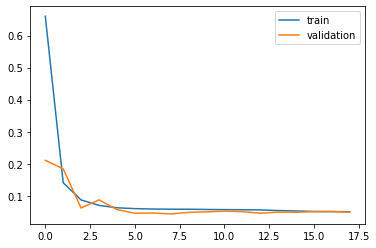


predict: [[32.18026678 22.78331346]]
real:      [[30.9 22.9]]

Train on 1003 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4719 - mean_squared_error: 0.4225 - val_loss: 0.2133 - val_mean_squared_error: 0.0761
Epoch 2/1000
 - 0s - loss: 0.1162 - mean_squared_error: 0.0253 - val_loss: 0.0620 - val_mean_squared_error: 0.0052
Epoch 3/1000
 - 0s - loss: 0.0783 - mean_squared_error: 0.0107 - val_loss: 0.1178 - val_mean_squared_error: 0.0164
Epoch 4/1000
 - 0s - loss: 0.0649 - mean_squared_error: 0.0068 - val_loss: 0.1187 - val_mean_squared_error: 0.0147
Epoch 5/1000
 - 0s - loss: 0.0621 - mean_squared_error: 0.0062 - val_loss: 0.0936 - val_mean_squared_error: 0.0090
Epoch 6/1000
 - 0s - loss: 0.0607 - mean_squared_error: 0.0059 - val_loss: 0.0853 - val_mean_squared_error: 0.0074
Epoch 7/1000
 - 0s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.0847 - val_mean_squared_error: 0.0072
Epoch 8/1000
 - 0s - loss: 0.0596 - mean_squared_error: 0.0058 - val_loss: 0.1112 - va

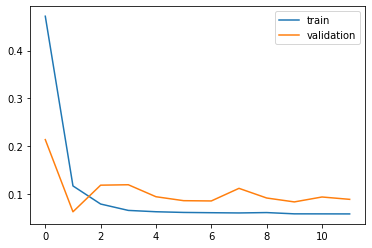


predict: [[31.00227565 22.50887085]]
real:      [[31.2 23.2]]

Train on 1002 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.4743 - mean_squared_error: 0.3505 - val_loss: 0.3673 - val_mean_squared_error: 0.1483
Epoch 2/1000
 - 0s - loss: 0.1247 - mean_squared_error: 0.0232 - val_loss: 0.1018 - val_mean_squared_error: 0.0159
Epoch 3/1000
 - 0s - loss: 0.0718 - mean_squared_error: 0.0084 - val_loss: 0.0728 - val_mean_squared_error: 0.0100
Epoch 4/1000
 - 0s - loss: 0.0630 - mean_squared_error: 0.0065 - val_loss: 0.0928 - val_mean_squared_error: 0.0145
Epoch 5/1000
 - 0s - loss: 0.0601 - mean_squared_error: 0.0059 - val_loss: 0.1078 - val_mean_squared_error: 0.0202
Epoch 6/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0059 - val_loss: 0.1017 - val_mean_squared_error: 0.0192
Epoch 7/1000
 - 0s - loss: 0.0588 - mean_squared_error: 0.0057 - val_loss: 0.0949 - val_mean_squared_error: 0.0179
Epoch 8/1000
 - 0s - loss: 0.0577 - mean_squared_error: 0.0055 - val_loss: 0.0867 - va

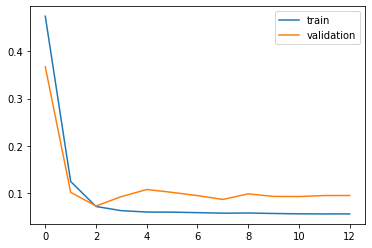


predict: [[30.62603597 22.35615275]]
real:      [[31.  21.1]]

Train on 1001 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.6119 - mean_squared_error: 0.6211 - val_loss: 0.0372 - val_mean_squared_error: 0.0015
Epoch 2/1000
 - 0s - loss: 0.1121 - mean_squared_error: 0.0242 - val_loss: 0.1498 - val_mean_squared_error: 0.0398
Epoch 3/1000
 - 0s - loss: 0.0779 - mean_squared_error: 0.0099 - val_loss: 0.1112 - val_mean_squared_error: 0.0185
Epoch 4/1000
 - 0s - loss: 0.0654 - mean_squared_error: 0.0073 - val_loss: 0.0835 - val_mean_squared_error: 0.0122
Epoch 5/1000
 - 0s - loss: 0.0604 - mean_squared_error: 0.0059 - val_loss: 0.0898 - val_mean_squared_error: 0.0114
Epoch 6/1000
 - 0s - loss: 0.0589 - mean_squared_error: 0.0057 - val_loss: 0.0657 - val_mean_squared_error: 0.0078
Epoch 7/1000
 - 0s - loss: 0.0583 - mean_squared_error: 0.0056 - val_loss: 0.0654 - val_mean_squared_error: 0.0077
Epoch 8/1000
 - 0s - loss: 0.0569 - mean_squared_error: 0.0053 - val_loss: 0.0677 - va

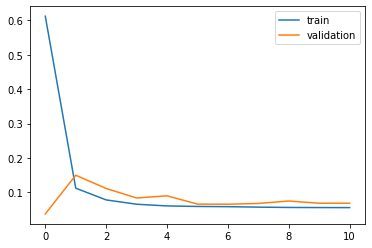


predict: [[29.18418131 20.78290231]]
real:      [[28.7 22.8]]

Train on 1000 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 0.8110 - mean_squared_error: 0.7919 - val_loss: 0.2653 - val_mean_squared_error: 0.0906
Epoch 2/1000
 - 0s - loss: 0.1879 - mean_squared_error: 0.0672 - val_loss: 0.1862 - val_mean_squared_error: 0.0652
Epoch 3/1000
 - 0s - loss: 0.0886 - mean_squared_error: 0.0135 - val_loss: 0.0645 - val_mean_squared_error: 0.0043
Epoch 4/1000
 - 0s - loss: 0.0711 - mean_squared_error: 0.0086 - val_loss: 0.1032 - val_mean_squared_error: 0.0148
Epoch 5/1000
 - 0s - loss: 0.0622 - mean_squared_error: 0.0063 - val_loss: 0.0782 - val_mean_squared_error: 0.0077
Epoch 6/1000
 - 0s - loss: 0.0599 - mean_squared_error: 0.0058 - val_loss: 0.0647 - val_mean_squared_error: 0.0044
Epoch 7/1000
 - 0s - loss: 0.0591 - mean_squared_error: 0.0056 - val_loss: 0.0731 - val_mean_squared_error: 0.0054
Epoch 8/1000
 - 0s - loss: 0.0582 - mean_squared_error: 0.0055 - val_loss: 0.0796 - va

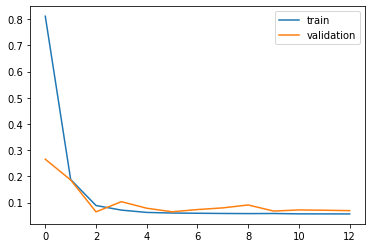


predict: [[33.13929141 22.64069012]]
real:      [[30.1 22.9]]

Maximum temperature
Test RMSE -------------------------- 1.802
Test VARIANCE ---------------------- -0.193
Test MAX-ERROR --------------------- 4.179
Test MEAN-ABSOLUTE-ERROR ----------- 1.452
Test MEDIAN-ABSOLUTE-ERROR --------- 1.324

Minimum temperature
Test RMSE -------------------------- 0.9307
Test VARIANCE ---------------------- -0.4502
Test MAX-ERROR --------------------- 2.775
Test MEAN-ABSOLUTE-ERROR ----------- 0.7446
Test MEDIAN-ABSOLUTE-ERROR --------- 0.6687


In [11]:
# to get index the last 30 days
days_to_predict = list(dataset.index[-30:])

mean_scaler = np.mean(values) + 1
dataset_scaled = dataset.div(mean_scaler)

NCV(dataset_scaled, days_to_predict, mean_scaler)